In [1]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
from sklearn import model_selection as sms
from sklearn import feature_selection as skf
from sklearn import linear_model as slm
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
import nibabel as nib
import os
import pickle
from torch import nn
from scipy.spatial import cKDTree
patch_sklearn()


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 1
# Load data
nrows = 256
ncols = 256
nslices = 160
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/orig/qsm/'
q_directory = os.listdir(q_directory)
q_directory = sorted(q_directory)
qu_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/lr_roi_ft'
qu_directory = os.listdir(qu_directory)
qu_directory = sorted(qu_directory)
s_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/orig/seg/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)
m_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/masks'
m_directory = os.listdir(m_directory)
m_directory = sorted(m_directory)
case_list = []
d_count = 0
if visualize == 1:
    for filename in q_directory:
    
        seg_filename = s_directory[d_count]
        laro_filename = qu_directory[d_count]
        mask_filename = m_directory[d_count]
        seg = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/orig/seg/'+seg_filename)
        mask = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/masks/'+mask_filename)
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata()[:nrows,:ncols,:nslices])
        qsm = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/orig/qsm/'+filename)
        qsms.append(qsm.get_fdata()[:nrows,:ncols,:nslices])

        laro = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/lr_roi_ft/'+laro_filename)
        laros.append(1000*laro.get_fdata()[:nrows,:ncols,:nslices])
        print('Appending arrays with segmentation',seg_filename,'QSM,',filename,
              'LARO,',laro_filename,'and mask',mask_filename)
        case_list.append(filename)
        n_cases = len(segs)
        d_count = d_count+1




Appending arrays with segmentation 01_roi_combined.nii QSM, 00001_qsm.nii.gz LARO, QSM_lrr_01.nii and mask mask01.nii
Appending arrays with segmentation 02_roi_combined.nii QSM, 00002_qsm.nii.gz LARO, QSM_lrr_02.nii and mask mask02.nii
Appending arrays with segmentation 03_roi_combined.nii QSM, 00003_qsm.nii.gz LARO, QSM_lrr_03.nii and mask mask03.nii
Appending arrays with segmentation 04_roi_combined.nii QSM, 00004_qsm.nii.gz LARO, QSM_lrr_04.nii and mask mask04.nii
Appending arrays with segmentation 05_roi_combined.nii QSM, 00005_qsm.nii.gz LARO, QSM_lrr_05.nii and mask mask05.nii
Appending arrays with segmentation 06_roi_combined.nii QSM, 00006_qsm.nii.gz LARO, QSM_lrr_06.nii and mask mask06.nii
Appending arrays with segmentation 07_roi_combined.nii QSM, 00007_qsm.nii.gz LARO, QSM_lrr_07.nii and mask mask07.nii
Appending arrays with segmentation 08_roi_combined.nii QSM, 00008_qsm.nii.gz LARO, QSM_lrr_08.nii and mask mask08.nii
Appending arrays with segmentation 09_roi_combined.nii Q

In [4]:
cv_names = {'CORNELL ID',
            ' OFF (pre-dbs updrs)',
            ' ON (pre-dbs updrs)',
            ' OFF meds ON stim 6mo',
            'Age',
            'Sex',
            'Ethnicity',
            'Race',
            'Disease Duration (year)',
            'Physician',
            ' pre op levadopa equivalent dose (mg)',
            ' Location',
            ' Target',
            ' Test medication status'}


# Load scores
file_dir = '/data/Ali/RadDBS-QSM/data/docs/dbs_03292024.csv'
motor_df = util.filter_data(file_dir,cv_names,True)
# Find cases with all required scores
cv_dict = util.filter_cases(motor_df,cv_names)
subs = cv_dict['CORNELL ID']
# Load extracted features
npy_dir = '/data/Ali/RadDBS-QSM/data/npy/new/'
phi_dir = '/data/Ali/RadDBS-QSM/data/phi/new/phi/'
roi_path = '/data/Ali/RadDBS-QSM/data/xlxs/new_segs.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)
print(np.unique(R_all))
ids = np.asarray(ID_all).astype(int)

# Use cases from only 1 rater
phys = cv_dict['Physician']
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(ids).astype(int),np.asarray(cv_dict['CORNELL ID'])[phys==1].astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
# Exclude GPi
c_cases_idx[ids == 9] = 0
c_cases_idx[ids == 36] = 0
# c_cases_idx[ids == 42] = 0
# c_cases_idx[ids == 52] = 0
c_cases_idx[ids == 53] = 0
# c_cases_idx[ids == 98] = 0
# c_cases_idx[ids == 108] = 0
print(np.sum(c_cases_idx))
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
print(len(s_cases_idx))
        
X_all_c = X_all[c_cases_idx,2:6,:]
X_all_c = (np.load('/data/Ali/RadDBS-QSM/src/jupyter/archive/X2h_sr.npy').T).reshape((30,4,1595))
print('Applying combat')
K_all_c = K_all[c_cases_idx,2:6,:]
R_all_c = R_all[c_cases_idx,2:6,:]
# Re-index the scored subjects with respect to complete cases

per_change = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' OFF meds ON stim 6mo'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_imp = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' ON (pre-dbs updrs)'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_updrs = cv_dict[' ON (pre-dbs updrs)'][s_cases_idx]
dd = cv_dict['Disease Duration (year)'][s_cases_idx]
ledd = cv_dict[' pre op levadopa equivalent dose (mg)'][s_cases_idx]
tmed = cv_dict[' Test medication status'][s_cases_idx]

age = cv_dict['Age'][s_cases_idx]
loc = cv_dict[' Location'][s_cases_idx]
sex = cv_dict['Sex'][s_cases_idx]
rce = cv_dict['Race'][s_cases_idx]
eth = cv_dict['Ethnicity'][s_cases_idx]
tgt = cv_dict[' Target'][s_cases_idx]
subsc = subs[s_cases_idx]
# Reshape keys and ROIs
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K_all_cu[:,:,-1] = 'disease_duration'
    K_all_cu[:,:,-1] = 'pre op levadopa equivalent dose (mg)'
    K_all_cu[:,:,-1] = ' Test medication status'
    K_all_cu[:,:,-1] = 'Physician'
    K_all_cu[:,:,-1] = 'Age'
    K_all_cu[:,:,-1] = 'Location'
    K_all_cu[:,:,-1] = 'Sex'
    K_all_cu[:,:,-1] = 'Race'
    K_all_cu[:,:,-1] = 'Ethnicity'
    
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
else:
    K_all_c = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
    R_all_c = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))

print(np.unique(R_all_c))

Keeping CORNELL ID
Keeping Age
Keeping Sex
Keeping Ethnicity
Keeping Race
Keeping Disease Duration (year)
Keeping Physician
Keeping  OFF (pre-dbs updrs)
Keeping  ON (pre-dbs updrs)
Keeping  pre op levadopa equivalent dose (mg)
Keeping  Location
Keeping  Target
Keeping  Test medication status
Keeping  OFF meds ON stim 6mo
{'Age', 'Sex', ' Target', ' pre op levadopa equivalent dose (mg)', ' OFF meds ON stim 6mo', 'Disease Duration (year)', ' Test medication status', 'Physician', ' OFF (pre-dbs updrs)', 'Ethnicity', ' ON (pre-dbs updrs)', 'CORNELL ID', ' Location', 'Race'}
['X_115_01.npy', 'X_115_02.npy', 'X_115_03.npy', 'X_115_04.npy', 'X_115_05.npy', 'X_115_06.npy', 'X_115_07.npy', 'X_115_08.npy', 'X_115_09.npy', 'X_115_10.npy', 'X_115_100.npy', 'X_115_101.npy', 'X_115_102.npy', 'X_115_104.npy', 'X_115_105.npy', 'X_115_106.npy', 'X_115_107.npy', 'X_115_108.npy', 'X_115_109.npy', 'X_115_11.npy', 'X_115_110.npy', 'X_115_111.npy', 'X_115_112.npy', 'X_115_113.npy', 'X_115_114.npy', 'X_115_1

In [5]:
n_cases = len(per_change)
results_ls_aug = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
r = 1

In [6]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"


In [7]:
Js = []
aug = True
err_var = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
c = 0
retrain = 0
if retrain == 1:
  for j in np.arange(c,len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train0 = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train0 <= 0.3
      idy = np.where(y_cat==1)
      # Cross validation
                                            
      X0_ss00,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                    X_train,train_index,X_test,
                                                    test_index,pre_updrs,loc,dd,tgt,None,
                                                    None,None,None,None,None,False,False,False)
      # 10
      cvn = 5
      cv_scores = np.zeros((cvn+1,1))
      rs = 1
      rcfs = 1000 
      (mu, sigma) = stats.norm.fit(y_train0)
      kappa = stats.skew(y_train0)
      print('Label distribution of:',mu,sigma,kappa)
      Q = 10 # np.ceil(10*(4/3)) # 10, r=0.67
      for jj in np.arange(Q):
        # Resample to avoid stratification errors
        while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss00 = np.append(X0_ss00,X0_ss00[idyr,:].reshape(1,-1),axis=0)
          y_train0 = np.append(y_train0,y_train0[idyr])
          y_cat = y_train0 <= 0.3
          rs = rs+1
          print('Resampled to size',y_train0.shape)
          y_train_n = y_train0
          X0_ss0_n = X0_ss00
        if aug == True: # 1.96*(4/3) -> nearest z
          y_train_n = np.append(y_train_n,y_train0+(np.ceil(4/3)*1.96*sigma)*np.random.normal(0,1,1))
          y_cat = y_train_n <= 0.3
          X0_ss0_n = np.append(X0_ss0_n,X0_ss00,axis=0)
      
      y_train = y_train_n
      X0_ss0 = X0_ss0_n
        
      for jj in np.arange(2,cvn+1): #cvn best
        skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
        skf_gen = skf_g.split(X0_ss0,y_cat)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          # Feature selection
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen)
          X0_ss = sel.fit_transform(X0_ss0,y_train)
          est_ls = lasso.fit(X0_ss,y_train)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
          print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)

        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X_test_sst = sel.transform(X_test_ss0)
        X0_ss = X0_sst
        X_test_ss = X_test_sst

      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        est_ls = lasso.fit(X0_sst,y_train)
        results_ls_aug[c] = est_ls.predict(X_test_sst)
        if results_ls_aug[c] < 0:
        #  results_ls_aug[c] = 0
            dx, y_n = cKDTree(X0_ss0_n).query(X_test_ss0, k=1)
            results_ls_aug[c] = y_train[y_n]
            print('Using nearest neighbor')
        print('Lasso predicts',str(np.round(results_ls_aug[c],4)),
              'for',subsc[c], 'case with',str(np.round(np.repeat(per_change,r)[c],2)),'using',X0_sst.shape[1],'features and selected CV',best_cv)
        # try:
        #   K_nz.append(np.squeeze(K_ss)[est_ls.coef_>0])
        # except:
        #   print('No features appended')
        c=c+1
  np.save('msw_results_ls_aug.npy',results_ls_aug)

else:
  results_ls_aug = np.load('msw_results_ls_aug.npy')

  


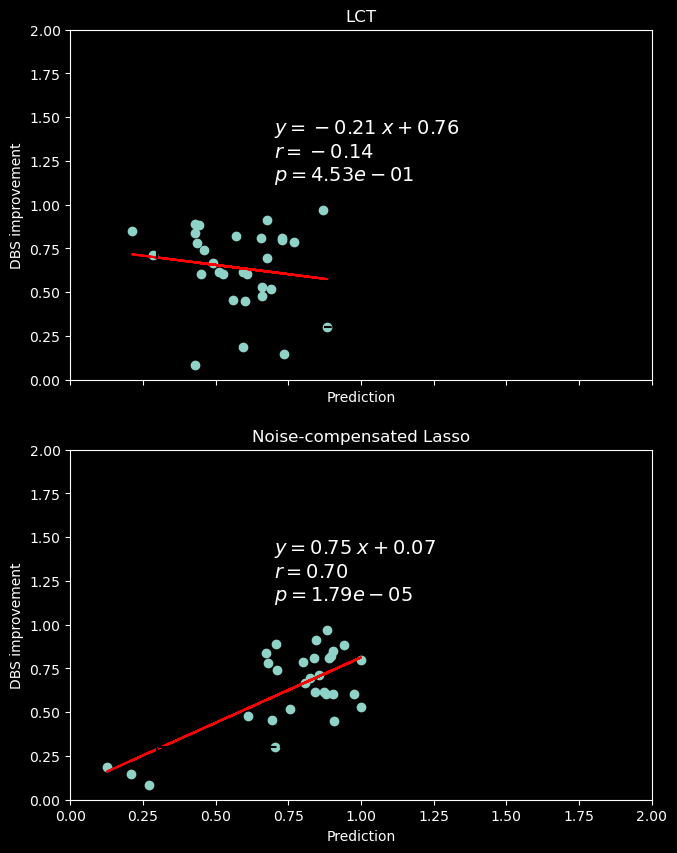

In [8]:
results_ls_aug[results_ls_aug>1] = 1
util.eval_prediction(np.vstack((pre_imp,
                               results_ls_aug,
                               )),
                               per_change,
                               ['LCT',
                                'Noise-compensated Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')
# Fix nearest neighbor problem
# Fix differing noise problem

In [13]:
from CorrelationStats import corrstats
corrstats.dependent_corr(linregress(per_change,results_ls_aug).rvalue,linregress(per_change,pre_imp).rvalue,linregress(pre_imp,results_ls_aug).rvalue,len(pre_imp),twotailed=False,conf_level=0.95,method='steiger')

(4.200033830470057, 0.00013010609789254612)

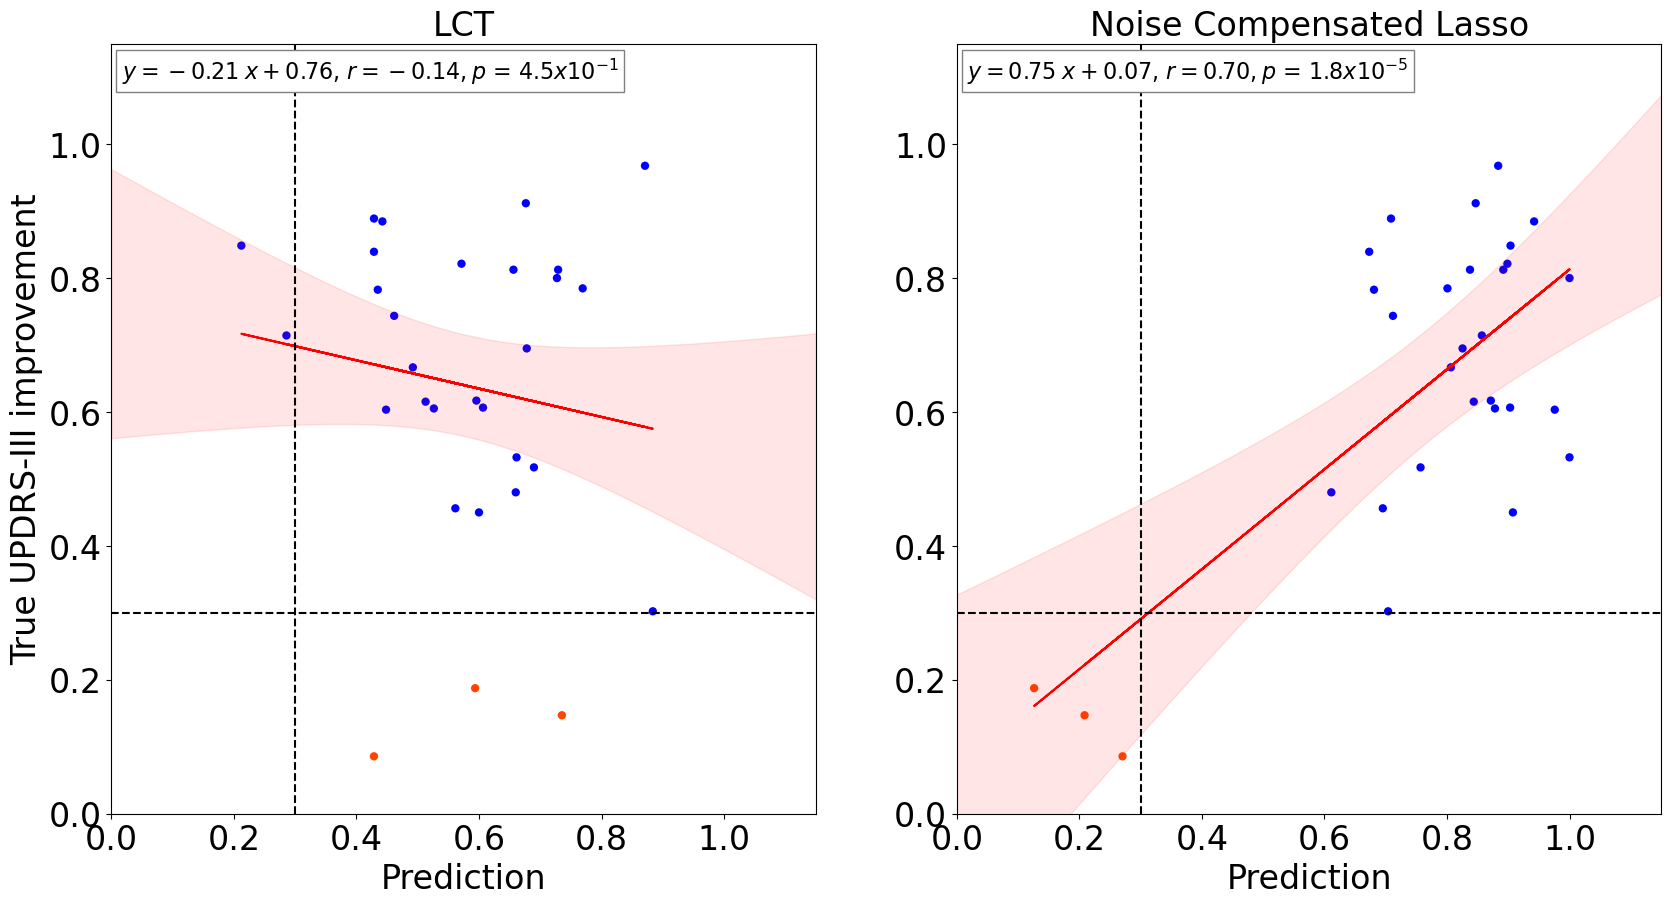

In [10]:
pre_imp = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' ON (pre-dbs updrs)'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
fs = 16
plt.rcParams['figure.figsize'] = [20, 10]
ylim = 1.15
fig,ax = plt.subplots(1,2)
col = np.where(per_change <= 0.3,'orangered','blue')
ax[0].scatter(pre_imp,per_change, c=col,linewidth=0)
lr = stats.linregress(pre_imp.T,per_change)
y_model = pre_imp*lr.slope+lr.intercept
ax[0].plot(pre_imp,y_model,color='r')
ax[0].set_ylim([0,ylim])
ax[0].set_xlim([0,ylim])
pl = r'$'+util.latex_sci(lr.pvalue,1)+'$'
# text = f"$y={lr_prepost.slope:0.2f}\; x{lr_prepost.intercept:+0.2f}$\n$r = {lr_prepost.rvalue:0.2f}$\n$p = {lr_prepost.pvalue:0.2e}$"
ax[0].text(0.015,0.945,f"$y={lr.slope:0.2f}\; x{lr.intercept:+0.2f}$, $r = {lr.rvalue:0.2f},${'$p$ = '+pl}",
                    ha='left', va='bottom', transform=ax[0].transAxes,fontsize=24//1.5,
                    bbox=dict(facecolor='white', edgecolor='gray'))  
ci,pi,x_line,y_line = util.confidence_interval(pre_imp,per_change,ylim)
ax[0].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].xaxis.set_tick_params(labelleft=True,labelsize=24)
ax[0].yaxis.set_tick_params(labelleft=True,labelsize=24)
ax[0].set_title('LCT',fontsize=24)
ax[0].set_ylabel('True UPDRS-III improvement',fontsize=24)
ax[0].set_xlabel('Prediction',fontsize=24)

col = np.where(per_change <= 0.3,'orangered','blue')
ax[1].scatter(results_ls_aug,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_aug),per_change)
y_model = results_ls_aug*lr.slope+lr.intercept
ax[1].plot(results_ls_aug,y_model,color='r')
pl = r'$'+util.latex_sci(lr.pvalue,1)+'$'
ax[1].text(0.015,0.945,f"$y={lr.slope:0.2f}\; x{lr.intercept:+0.2f}$, $r = {lr.rvalue:0.2f},${'$p$ = '+pl}",
                    ha='left', va='bottom', transform=ax[1].transAxes,fontsize=24//1.5,
                    bbox=dict(facecolor='white', edgecolor='gray'))  
ci,pi,x_line,y_line = util.confidence_interval(results_ls_aug,per_change,ylim)
ax[1].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].xaxis.set_tick_params(labelleft=True,labelsize=24)
ax[1].yaxis.set_tick_params(labelleft=True,labelsize=24)
ax[1].set_title('Noise Compensated Lasso',fontsize=24)
# ax[1].set_ylabel('True improvement',fontsize=16)
ax[1].set_xlabel('Prediction',fontsize=24)
plt.ylim([0,ylim])
plt.xlim([0,ylim])
plt.style.use('default')

(0.0, 1.15)

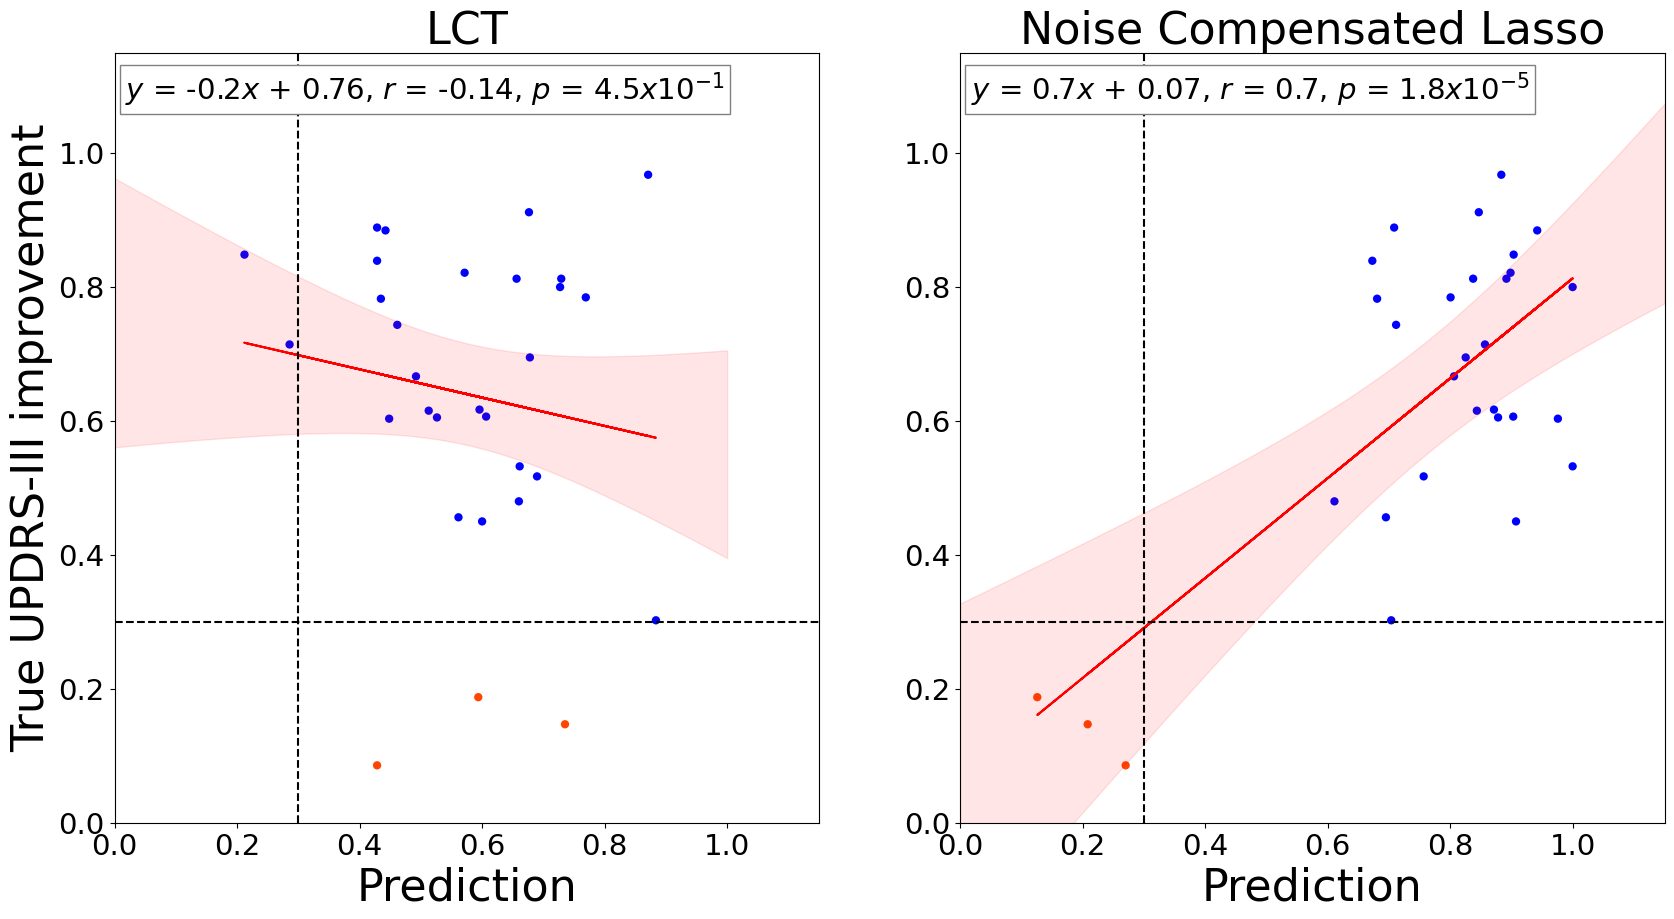

In [11]:
ylim = 1.15
fs = 32
ofx = 0.25
ofy = 0.745
plt.rcParams['figure.figsize'] = [20, 10]
fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
col = np.where(per_change <= 0.3,'orangered','blue')
ax[0].scatter(pre_imp,per_change, c=col,linewidth=0)
lr = stats.linregress(pre_imp,per_change)
y_model = pre_imp*lr.slope+lr.intercept
ax[0].plot(pre_imp,y_model,color='r')
pl = r'$'+util.latex_sci(lr.pvalue,1)+'$'
ax[0].text(0.015,0.9275,'$y$ = '+str(np.round(lr.slope,1))+'$x$ + '+str(np.round(lr.intercept,2))+', '+'$r$ = '+str(np.round(lr.rvalue,2))+', '+'$p$ = '+pl,
                    ha='left', va='bottom', transform=ax[0].transAxes,fontsize=fs//1.5,
                    bbox=dict(facecolor='white', edgecolor='gray'))  
ci,pi,x_line,y_line = util.confidence_interval(pre_imp,per_change,1)
ax[0].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].set_title('LCT',fontsize=fs)
ax[0].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0].set_ylabel('True UPDRS-III improvement',fontsize=fs)
ax[0].set_xlabel('Prediction',fontsize=fs)
ax[0].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)

ax[1].scatter(results_ls_aug,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_aug),per_change)
y_model = results_ls_aug*lr.slope+lr.intercept
ax[1].plot(results_ls_aug,y_model,color='r')
pl = r'$'+util.latex_sci(lr.pvalue,1)+'$'
ax[1].text(0.015,0.9275,'$y$ = '+str(np.round(lr.slope,1))+'$x$ + '+str(np.round(lr.intercept,2))+', '+'$r$ = '+str(np.round(lr.rvalue,2))+', '+'$p$ = '+pl,
                    ha='left', va='bottom', transform=ax[1].transAxes,fontsize=fs//1.5,
                    bbox=dict(facecolor='white', edgecolor='gray'))  
ci,pi,x_line,y_line = util.confidence_interval(results_ls_aug,per_change,ylim)
ax[1].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].set_title('Noise Compensated Lasso',fontsize=fs)
ax[1].set_xlabel('Prediction',fontsize=fs)
ax[1].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
plt.xlim(0,ylim)
plt.ylim(0,ylim)